In [3]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
aggregated_data = []
file_paths = glob.glob("*.csv")

for file in file_paths:    
    # Parse header
    with open(file, "r") as f:
        # Read the first three lines (header)
        line1 = f.readline().strip()  # Line 1: Date and time
        line2 = f.readline().strip()  # Line 2: MFC1, MFC2, t_huber, t_sht, h_sht
        line3 = f.readline().strip()  # Line 3: psmethod, channel, valve0, valve1, flow0, flow1, set_temp, set_RH
    
    # Extract parameters from Line 2 using regex
    mfc1 = float(re.search(r"MFC1:([-\d.]+)sccm", line2).group(1))  # Allow negative values
    mfc2 = float(re.search(r"MFC2:([-\d.]+)sccm", line2).group(1))  # Allow negative values
    t_sht = float(re.search(r"t_sht:\s*([-\d.]+)", line2).group(1))  # Allow negative values
    h_sht = float(re.search(r"h_sht:\s*([-\d.]+)", line2).group(1))  # Allow negative values
    
    # Extract parameters from Line 3 using regex
    channel = re.search(r"channel:\s*(\S+)", line3).group(1)  # Extract channel name
    
    # Calculate oxygen concentration
    o2_conc = (mfc2 / (mfc1 + mfc2)) * 20.9
    
    # Read data (skip the first 3 lines, which are headers)
    df = pd.read_csv(file, sep=";", skiprows=4, header=None, 
                     names=["Time", "Voltage", "Current", "DataType"], 
                     usecols=[0, 1, 2, 3], engine="python", 
                     converters={
                         "Time": lambda x: float(x.strip()),
                         "Voltage": lambda x: float(x.strip()),
                         "Current": lambda x: float(x.strip()),
                         "DataType": lambda x: x.strip()
                     })
    
    # Process Current data
    current_data = df[df["DataType"] == "Current"].copy()
    current_data["Polarization"] = current_data["Voltage"].apply(
        lambda x: "Negative" if x < 0 else "Positive")
    
    # Group by polarization
    grouped = current_data.groupby("Polarization", sort=False)
    for pol, group in grouped:
        group = group.sort_values("Time")
        if len(group) == 0:
            continue
        
        # Calculate end current and charge
        end_current = group["Current"].iloc[-1]
        time_diff = group["Time"].diff().fillna(0)
        charge = (group["Current"] * time_diff).sum()
        
        aggregated_data.append({
            "Time": group["Time"].iloc[-1], 
            "O2": o2_conc,
            "Temperature": t_sht,
            "Humidity": h_sht,
            "Channel": channel,
            "Polarization": pol,
            "EndCurrent": end_current,
            "Charge": charge
        })

df_agg = pd.DataFrame(aggregated_data)

### Task 1: Visualize current as a function of oxygen concentration for each channel

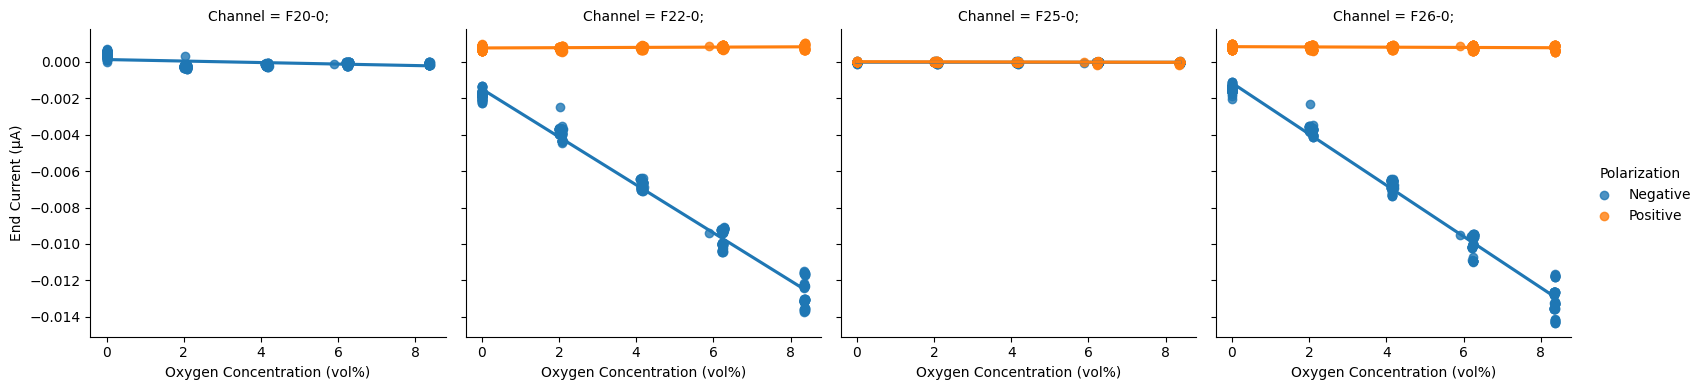

In [33]:
g = sns.lmplot(data=df_agg, x="O2", y="EndCurrent", col="Channel", hue="Polarization",
               ci=None, height=4, aspect=1)
g.set_axis_labels("Oxygen Concentration (vol%)", "End Current (μA)")
plt.show()

### Task 2: Determine effective polarization

In [34]:
correlations = df_agg.groupby(["Channel", "Polarization"]).apply(
    lambda x: x[["O2", "EndCurrent"]].corr().iloc[0, 1], include_groups = False
)

print("Correlations between O2 and EndCurrent:")
print(correlations.sort_values(ascending=False))

Correlations between O2 and EndCurrent:
Channel  Polarization
F22-0;   Positive        0.233209
F25-0;   Negative       -0.045954
F26-0;   Positive       -0.189195
F25-0;   Positive       -0.310798
F20-0;   Negative       -0.483211
F26-0;   Negative       -0.992888
F22-0;   Negative       -0.992911
dtype: float64


The code above calculates the Pearson correlation coefficient between `O2` (oxygen concentration) and `EndCurrent` (end current) for each combination of `Channel` and `Polarization`. **The strongest and most effective relationship** was observed for **negative polarization** on the **F22-0** and **F26-0** channels, which have the strongest negative correlations (-0.992911 and -0.992888, respectively). These strong correlations indicate a consistent and predictable relationship between `O2` and `EndCurrent`, making them highly effective for sensing oxygen levels, despite the inverse relationship. <br>

On the other hand, **positive polarization** on the **F22-0** channel shows a weak positive correlation (0.233209), indicating it is less effective for sensing oxygen levels due to the near-zero end currents typically observed during positive polarization. Additionally, the **F20-0** channel (Negative polarization) shows a moderate negative correlation (-0.483211), suggesting it is underperforming, while the **F25-0** channel (Negative polarization) has an extremely weak correlation (-0.045954), indicating it is likely corrupted. With these results in mind, we should focus on optimizing the **negative polarization step** for the **F22-0** and **F26-0** channels, as they show the most promise for accurate oxygen sensing. Positive polarization should be excluded from calibration efforts due to its inherent limitations, and underperforming or corrupted sensors (e.g., F20-0 and F25-0) should be investigated or replaced.

### Task 3: Visualize dependencies

In [35]:
def plot_dependencies(x, y, hue, axis1, axis2, title, xlabel, ylabel):
    sns.scatterplot(data=df_agg, x=x, y=y, hue=hue, ax=axes[axis1, axis2])
    axes[axis1, axis2].set_title(title)
    axes[axis1, axis2].set_xlabel(xlabel)
    axes[axis1, axis2].set_ylabel(ylabel)

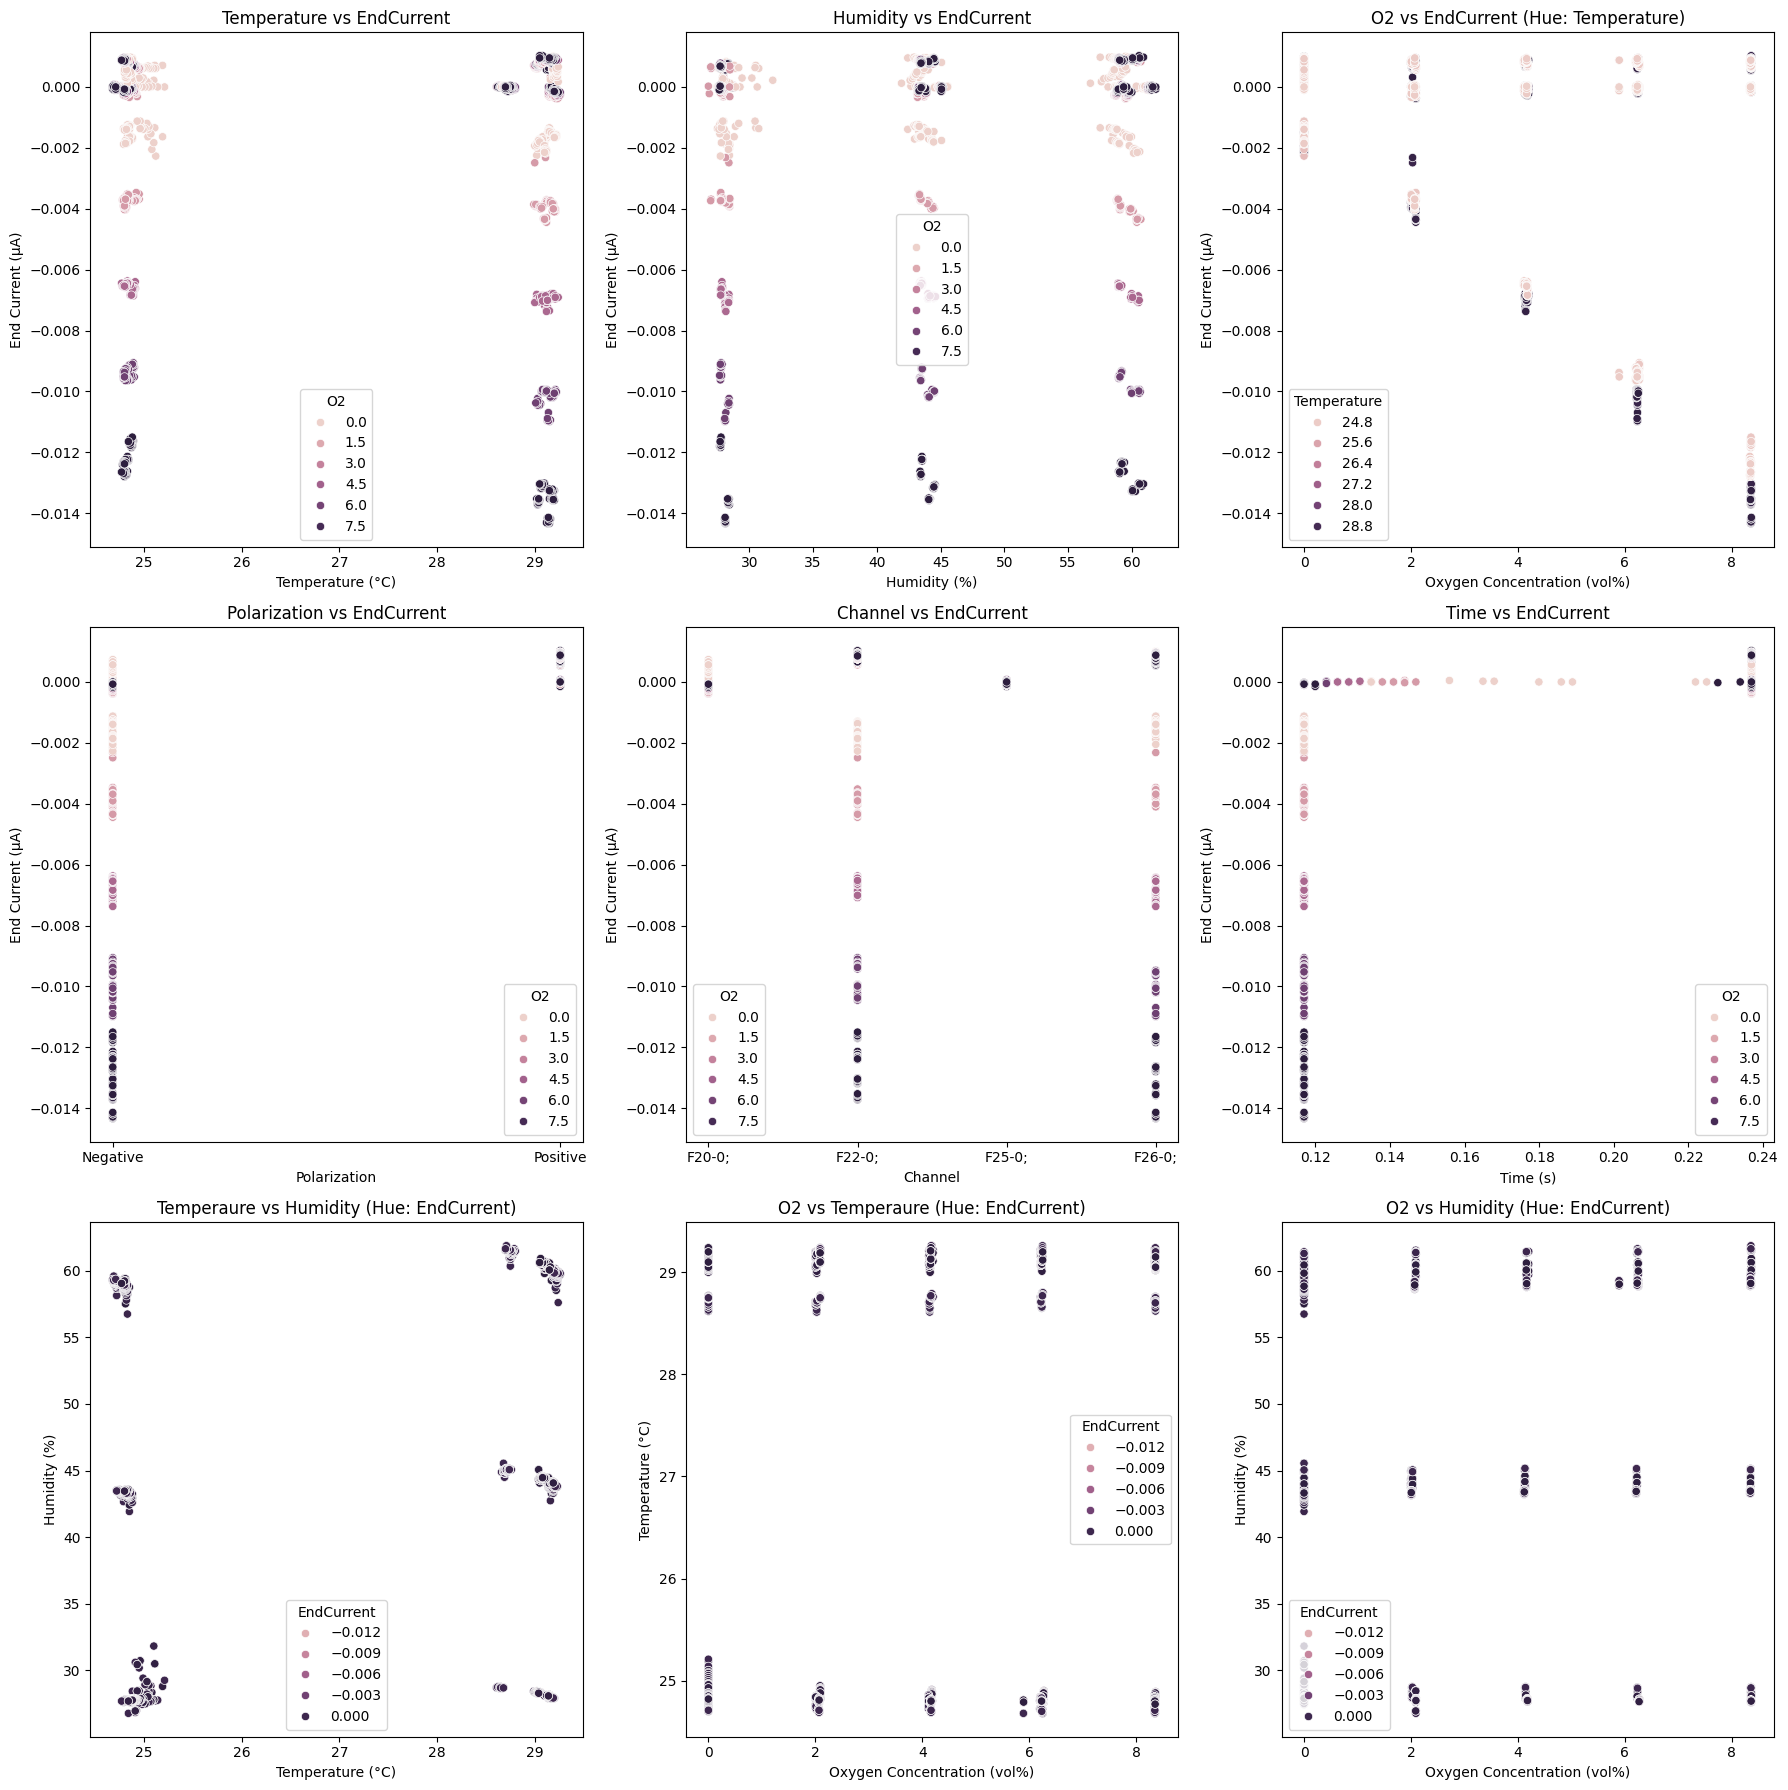

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Temperature vs EndCurrent with O2 as hue
plot_dependencies("Temperature", "EndCurrent", "O2", 0, 0, "Temperature vs EndCurrent", "Temperature (°C)", "End Current (μA)")

# Plot 2: Humidity vs EndCurrent with O2 as hue
plot_dependencies("Humidity", "EndCurrent", "O2", 0, 1, "Humidity vs EndCurrent", "Humidity (%)", "End Current (μA)")

# Plot 3: O2 vs EndCurrent with Temperature as hue
plot_dependencies("O2", "EndCurrent", "Temperature", 0, 2, "O2 vs EndCurrent (Hue: Temperature)", "Oxygen Concentration (vol%)", "End Current (μA)")

# Plot 4: Polarization vs EndCurrent with O2 as hue
plot_dependencies("Polarization", "EndCurrent", "O2", 1, 0, "Polarization vs EndCurrent", "Polarization", "End Current (μA)")

# Plot 5: Channel vs EndCurrent with O2 as hue
plot_dependencies("Channel", "EndCurrent", "O2", 1, 1, "Channel vs EndCurrent", "Channel", "End Current (μA)")

# Plot 6: Time vs EndCurrent with O2 as hue
plot_dependencies("Time", "EndCurrent", "O2", 1, 2, "Time vs EndCurrent", "Time (s)", "End Current (μA)")

# Plot 7: Temperature vs Humidity with EndCurrent as hue
plot_dependencies("Temperature", "Humidity", "EndCurrent", 2, 0, "Temperaure vs Humidity (Hue: EndCurrent)", "Temperature (°C)", "Humidity (%)")

# Plot 8: O2 vs Temperature with EndCurrent as hue
plot_dependencies("O2", "Temperature", "EndCurrent", 2, 1, "O2 vs Temperaure (Hue: EndCurrent)", "Oxygen Concentration (vol%)", "Temperature (°C)")

# Plot 9: O2 vs Humidity with EndCurrent as hue
plot_dependencies("O2", "Humidity", "EndCurrent", 2, 2, "O2 vs Humidity (Hue: EndCurrent)", "Oxygen Concentration (vol%)", "Humidity (%)")

plt.tight_layout()
plt.show()

The scatter plots indicate that the EndCurrent is influenced by multiple factors, including `Temperature`, `Humidity`, `Oxygen Concentration`, `Polarization`, `Channel` and `Time`. Higher oxygen concentrations consistently result in lower end currents, regardless of other variables. This trend is consistent across different temperatures, humidities, channels, and polarizations, highlighting the **strong dependence** of end current on oxygen concentration. <br>

It's interesting to note that there are a lot more instances of negative polarization and all the instances with positive polarization have near zero end current values. <br>
Additionally, most of the instances belong to channels *F22-0* and *F26-0*.
This fortifies the theory that instances which belong to these channels and with **negative polarization** are of interest to us. 

### Task 4: Detect corrupted sensors

In [39]:
corr_threshold = 0.5

# Group by Channel and Polarization  
sensor_correlations = df_agg.groupby(["Channel", "Polarization"]).apply(
    lambda x: x[["O2", "EndCurrent"]].corr().iloc[0, 1], include_groups=False
)

bad_sensors = sensor_correlations[sensor_correlations.abs() < corr_threshold].index.tolist()

print("Correlations between O2 and EndCurrent (by Channel and Polarization):")
print(sensor_correlations)

print("\nPotentially corrupted sensors (low correlation):")
print(bad_sensors)

Correlations between O2 and EndCurrent (by Channel and Polarization):
Channel  Polarization
F20-0;   Negative       -0.483211
F22-0;   Negative       -0.992911
         Positive        0.233209
F25-0;   Negative       -0.045954
         Positive       -0.310798
F26-0;   Negative       -0.992888
         Positive       -0.189195
dtype: float64

Potentially corrupted sensors (low correlation):
[('F20-0;', 'Negative'), ('F22-0;', 'Positive'), ('F25-0;', 'Negative'), ('F25-0;', 'Positive'), ('F26-0;', 'Positive')]


All channels show strong correlations between `O2` and `EndCurrent` for **negative polarization**, with the exception of **F25-0**, indicating that these sensors are functioning correctly. The negative polarization correlation for channel **F25-0** is extremely weak, indicating that this sensor is likely corrupted. It does not show the expected relationship between O2 and EndCurrent. The low correlations for **positive polarization** are expected because positive polarization results in near-zero end currents, making the relationship with O2 less meaningful. <br>

### Task 5: Calibrate functional sensors

In [40]:
results = []
for channel in df_agg["Channel"].unique():
    if channel in bad_sensors:
        continue
    for pol in ["Negative", "Positive"]:
        df_sub = df_agg[(df_agg["Channel"] == channel) & 
                        (df_agg["Polarization"] == pol)]
        if len(df_sub) < 3:
            continue
        
        X = df_sub[["EndCurrent"]]
        y = df_sub["O2"]
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        
        results.append({
            "Channel": channel,
            "Polarization": pol,
            "R2": r2_score(y, y_pred),
            "MAE": mean_absolute_error(y, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y, y_pred)),
            "Slope": model.coef_[0]
        })

df_results = pd.DataFrame(results)
print("\nCalibration Results:")
print(df_results)


Calibration Results:
  Channel Polarization        R2       MAE      RMSE         Slope
0  F20-0;     Negative  0.233493  2.252956  2.587216  -5654.238289
1  F22-0;     Negative  0.985872  0.295385  0.351252   -748.047824
2  F22-0;     Positive  0.054387  2.415352  2.873688   7167.342479
3  F25-0;     Negative  0.002112  2.522496  2.951863  -3729.812363
4  F25-0;     Positive  0.096595  2.346724  2.796838 -24970.225254
5  F26-0;     Negative  0.985826  0.275242  0.351812   -700.912773
6  F26-0;     Positive  0.035795  2.498289  2.901700  -5104.606218


The calibration results, obtained using **linear regression**, reveal that the **negative polarization** for the **F22-0** and **F26-0** channels is the most effective for accurate oxygen level measurements. The linear regression models were trained on the relationship between `EndCurrent` (independent variable) and `O2` (dependent variable) for each combination of `Channel` and `Polarization`. For **F22-0** and **F26-0** (Negative polarization), the models show high R² values (0.985872 and 0.985826, respectively), low MAE (0.295385 and 0.275242), and low RMSE (0.351252 and 0.351812), indicating a strong and consistent predictive performance. <br>

The negative slopes (-748.047824 and -700.912773) reflect the inverse relationship between `O2` and `EndCurrent`, which is accounted for in the calibration. In contrast, the **positive polarization** for these channels performs poorly, with low R² values (0.054387 and 0.035795) and high MAE/RMSE, as expected due to near-zero end currents. The **F20-0** channel (Negative polarization) underperforms, with a low R² (0.233493) and high MAE/RMSE, while the **F25-0** channel (Negative polarization) is likely corrupted, showing an extremely low R² (0.002112) and an unrealistic slope (-3729.812363). <br>
Based on these results, we should focus on using the **negative polarization step** for the **F22-0** and **F26-0** channels for accurate oxygen sensing, exclude positive polarization due to its limitations, and investigate or replace underperforming or corrupted sensors like **F20-0** and **F25-0**.

### Task 6: Analyze humidity impact

In [41]:
X = df_agg[["EndCurrent", "Humidity"]]  # Independent variables: EndCurrent and Humidity
y = df_agg["O2"]  # Dependent variable: O2

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

results = {
    "R2": r2_score(y, y_pred),
    "MAE": mean_absolute_error(y, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y, y_pred)),
    "Slope_EndCurrent": model.coef_[0],  
    "Slope_Humidity": model.coef_[1],   
    "Intercept": model.intercept_
}


print("Multivariate Calibration Results (with Humidity Compensation):")
print(results)

Multivariate Calibration Results (with Humidity Compensation):
{'R2': 0.09580206380576095, 'MAE': np.float64(2.401595941878146), 'RMSE': np.float64(2.8090811719237427), 'Slope_EndCurrent': np.float64(-224.35614954878022), 'Slope_Humidity': np.float64(0.003423842333872077), 'Intercept': np.float64(3.5734578472570533)}


The results from the multivariate calibration model reveal several key insights into the relationship between `EndCurrent`, `Humidity`, and `O2`. <br>
The **low R² value (0.0958)** indicates that the model explains only **9.58%** of the variance in oxygen concentration, suggesting **poor predictive performance**. <br>
This is further supported by the **high MAE (2.4016)** and **RMSE (2.8091)**, which show that the model's predictions deviate significantly from the actual values. <br>
The **negative slope for `EndCurrent` (-224.3561)** confirms the expected inverse relationship between `EndCurrent` and `O2`, but the large magnitude of the slope indicates high sensitivity to changes in `EndCurrent`. <br>

On the other hand, the **small positive slope for `Humidity` (0.0034)** suggests that humidity has a **minimal impact** on the model's predictions, implying that it may not be a significant factor in the current dataset or that its effect is not well-captured by the linear model. Overall, these results highlight the limitations of the linear regression approach and suggest that the relationship between these variables may be **nonlinear** or influenced by additional factors not included in the model. To improve accuracy, future work should explore **nonlinear modeling techniques**, incorporate **additional variables** (e.g., temperature, polarization), or consider **advanced machine learning algorithms** to better capture the complex behavior of the sensors.